# 201601615 이의찬

# 1. 지정 주제

## 영화: 위플래쉬

광기에 가까운 교수와 드럼 연주자의 성장과 몰락을 담은 영화이다. <br>
이 영화는 공부를 가장 전투적으로 했던 고등학교 3학년 때 보았다.<br>
고3때, 영어학원을 다녔고 그 학원은 숙제를 하지 않으면 매를 맞았다. <br>
한 번, 학원에서 숙제를 2개 내주었고 둘 다 하지 않았다. <br>
이 때 세게 맞음으로써 그 다음부터 꾸준히 숙제를 했고 결국 영어 성적이 올랐다.<br>
<br>
그리고 나서 이 영화를 보았고, 폭력으로 사람을 성장시키는 관점에 대해 생각하게 되었고<br>
큰 충격으로 남아서 선정하게 되었다.<br>
<br>
기술적인 이유는 이 영화는 사람들의 호불호가 갈리고 의견의 대립이 첨예하기 때문이다.<br>
네이버 평점은 6점이고 다음 영화 평점은 8.4점이다. <br>
하지만 찬반수를 제일 많이 받은 댓글은 평점이 5점이고 평점 1점의 댓글도 상위 10개 안에 있다.<br>
<br>
또한 적절한 데이터 수이다. <br>
원래 '인터스텔라'를 선정하였으나 5000개가 넘는 너무 많은 데이터와 <br>
데이터의 평점이 너무 높고 뒤로 갈수록 댓글 또한 적어서 극적인 긍정과 부정의 차이를 보기 힘들었다.<br>
<br>
이러한 이유로 '위플래쉬'를 선정하게 되었다.

In [1]:
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By # find_element 를 할 때, 속성값 관리
from urllib.request import urlopen
from tqdm.notebook import tqdm
from wordcloud import WordCloud
from collections import Counter
from konlpy.tag import Okt
import matplotlib.pyplot as plt
import time

okt = Okt()

In [2]:
driver_path = "chromedriver.exe" # 경로명: 현재 폴더로 되어있음
movie_url = r"https://movie.daum.net/moviedb/grade?movieId=83493" # 영화: 위플래쉬

### selenium 드라이버

In [3]:
driver = webdriver.Chrome(driver_path)
driver.implicitly_wait(3) # 열리는 시간 3초 대기
driver.get(movie_url)
time.sleep(2)

C:\Users\outda\AppData\Local\Temp\ipykernel_3972\1645013352.py:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(driver_path)


## 1. 영화 리뷰 가져오기

In [214]:
# user_count = driver.find_element(
#     By.CLASS_NAME, "txt_netizen"
# ).text.strip("()명") # 평점을 남긴 네티즌 수

# more_count = (int(user_count) - 10) // 30 + 1 # more 버튼 누르는 총 횟수

# more_button = '//*[@id="alex-area"]/div/div/div/div[3]/div[1]/button' # 더보기 버튼

# for i in tqdm(range(more_count)):
#     driver.find_element("xpath", more_button).click()
#     time.sleep(2)

  0%|          | 0/49 [00:00<?, ?it/s]

In [215]:
# # html 텍스트 파일 저장 코드
# html = driver.page_source
# text_file = open('whiplash_review_data.txt', 'w', encoding='utf-8')
# text_file.write(html)
# text_file.close()

#### driver.page_source 사용 이유

```python
html = urlopen(movie_url)
soup = BeautifulSoup(html.read(), "html.parser")
```

`BeautifulSoup`을 사용할 경우 모든 태그를 가져오지 않는다.(::after로 숨겨져 있음) <br>
`driver.page_source`를 사용하여 현재 렌더링 된 페이지의 모든 `Elements`를 모두 가져오고 selenium으로 작업한 url 정보를 html로 가져온다. <br>


In [4]:
# html = driver.page_source # selenium으로 작업한 url 정보를 html로 가져옴
with open('whiplash_review_data.txt', 'r', encoding='utf-8') as f:
    html = f.read()
    f.close()

soup = BeautifulSoup(html, "html.parser")

comments = []
ratings = []

reviews = soup.find_all("div", {"class": "cmt_info"})

for review in tqdm(reviews):
    comment = review.find("p", {"class": "desc_txt font_size_"}) # 댓글
    
    if not comment:
        # 댓글을 적지 않고 평점만 줬다면 무시
        continue
        
    rating = int(review.find("div").text) # 평점: 첫번째 div
    comment = comment.text.strip() # 댓글
    
    ratings.append(rating)
    comments.append(comment)

  0%|          | 0/1453 [00:00<?, ?it/s]

## 2. 워드 클라우드 그리기

#### 자주 쓰이는 함수

In [5]:
# from konlpy.tag import Okt
# from collections import Counter
# from wordcloud import WordCloud

# okt = Okt()

def okt_pos_by_filter(text:str, filter=['Noun', 'Verb', 'Adjective']):
    '''
    okt를 이용해서 단어 필터링하는 함수
    문장을 필터링해서 반환(기본값: 명사, 동사, 형용사)
    '''
    result = []
    for t in okt.pos(text, norm=True, stem=True):
        if t[1] in filter:
            result.append(t[0])
            
    return result

def remove_meaningless_words(words):
    '''의미없는 단어 삭제하는 함수'''
    
    # 한 글자로 이루어진 단어 제거
    stopword_list = []
    
    for word in words:
        if len(word) == 1:
            stopword_list.append(word)

    for stopword in stopword_list:
        words.pop(stopword)

    # 의미없는 동사 제거
    verbs = ['하다', '보다', '있다', '되다', '이다', '이렇다', '그렇다', '않다', '같다', '이겠다']
    
    for v in verbs:
        if v in words:
            words.pop(v)
    
    return words

def generate_wc_frequencies(word_count):
    wc = WordCloud(background_color='white', max_words=5000, font_path=r'C:\Windows\Fonts\gulim.ttc')
    return wc.generate_from_frequencies(word_count)

### 2-1. 전체, 긍정, 부정 평가 단어 처리하기

전체: `all_comment_words`, `all_comments_word_count`

긍정: `pos_comment_words`, `pos_comment_word_count`

부정: `neg_comment_words`, `neg_comment_word_count`

In [7]:
# 댓글의 명사, 동사, 형용사만 추출
all_comment_words = []
pos_comment_words = []
neg_comment_words = []

for comment, rating in zip(comments, ratings):
    all_comment_words += okt_pos_by_filter(comment)
    if rating > 7: pos_comment_words += okt_pos_by_filter(comment)
    elif rating < 4: neg_comment_words += okt_pos_by_filter(comment)
        
all_comment_word_count = Counter(all_comment_words)
all_comment_word_count = remove_meaningless_words(all_comment_word_count)

pos_comment_word_count = Counter(pos_comment_words)
pos_comment_word_count = remove_meaningless_words(pos_comment_word_count)

neg_comment_word_count = Counter(neg_comment_words)
neg_comment_word_count = remove_meaningless_words(neg_comment_word_count)    

### 2-3. 워드 클라우드

#### 2-3-1. 전체

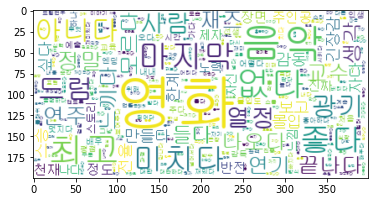

In [8]:
all_wc = generate_wc_frequencies(all_comment_word_count)
plt.imshow(all_wc, interpolation="bilinear")
plt.show()

#### 2-3-2. 긍정

In [ ]:
pos_wc = generate_wc_frequencies(pos_comment_word_count)
plt.imshow(pos_wc, interpolation="bilinear")
plt.show()

#### 2-3-3. 부정

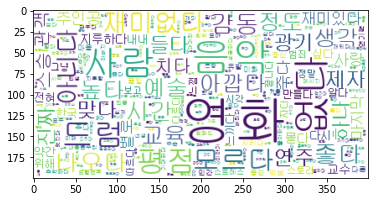

In [222]:
neg_wc = generate_wc_frequencies(neg_comment_word_count)
plt.imshow(neg_wc, interpolation="bilinear")
plt.show()

### 2-4 결과 해석

## 3. 분류기 학습시키기